In [11]:
import matplotlib.pyplot as plt
import torch
import os
import sys

from einops import rearrange, repeat
from pathlib import Path
import tempfile
import subprocess

# Reproducibility
torch.manual_seed(0)

# Ensure local package is importable
REPO_ROOT = Path.cwd().resolve().parents[1]
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

HAS_SPEAR = True
try:
    from spear.ops import btp as btp_ops
    from spear.ops.btp.interface import DH
except Exception as e:
    print(f"[warn] spear import failed: {e}")
    btp_ops = None
    DH = 16  # fallback value
    HAS_SPEAR = False

PALETTE = {
    "ref_log": "#ff7f0e",          # orange
    "ref_two": "#1f77b4",          # blue (two-pass reference)
    "ref_log_stable": "#9467bd",   # purple
    "unfused": "#d62728",          # red
    "unfused_stable": "#8c564b",   # brown
}

def _run_unfused_subproc(A_path: str, x_path: str, out_dir: str, variant: str, do_backward: bool):
    code = f"""
import os, sys, torch
sys.path.insert(0, r"{str(REPO_ROOT)}")
from spear.ops import btp as btp_ops
A = torch.load(r"{A_path}").contiguous()
x = torch.load(r"{x_path}").contiguous()
A.requires_grad_({str(do_backward)})
x.requires_grad_({str(do_backward)})
y = btp_ops(A, x, k=2, output_dtype=torch.float32)
torch.save(y.detach(), r"{out_dir}/y.pt")
if {str(do_backward)}:
    y.float().sum().backward()
    torch.save(x.grad.detach().float(), r"{out_dir}/dx.pt")
    torch.save(A.grad.detach().float(), r"{out_dir}/dA.pt")
"""
    script_path = Path(out_dir) / "_runner.py"
    script_path.write_text(code)
    env = os.environ.copy()
    env["SPEAR_USE_UNFUSED_STABLE"] = "1" if variant == "unfused_stable" else "0"
    env["PYTHONPATH"] = f"{str(REPO_ROOT)}:{env.get('PYTHONPATH','')}"
    python = sys.executable
    subprocess.run([python, str(script_path)], check=True, env=env)


def nb_unfused_forward(A: torch.Tensor, x: torch.Tensor, variant: str = "unfused", dtype: torch.dtype = torch.float16) -> torch.Tensor:
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA required for unfused kernels.")
    with tempfile.TemporaryDirectory() as td:
        td = Path(td)
        A_path, x_path = str(td / "A.pt"), str(td / "x.pt")
        torch.save(A.to("cuda", dtype=dtype), A_path)
        torch.save(x.to("cuda", dtype=dtype), x_path)
        _run_unfused_subproc(A_path, x_path, str(td), variant=variant, do_backward=False)
        y = torch.load(td / "y.pt", map_location="cuda")
    return y


def nb_unfused_backward(A: torch.Tensor, x: torch.Tensor, variant: str = "unfused", dtype: torch.dtype = torch.float16):
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA required for unfused kernels.")
    with tempfile.TemporaryDirectory() as td:
        td = Path(td)
        A_path, x_path = str(td / "A.pt"), str(td / "x.pt")
        torch.save(A.to("cuda", dtype=dtype), A_path)
        torch.save(x.to("cuda", dtype=dtype), x_path)
        _run_unfused_subproc(A_path, x_path, str(td), variant=variant, do_backward=True)
        y = torch.load(td / "y.pt", map_location="cuda")
        dx = torch.load(td / "dx.pt", map_location="cuda")
        dA = torch.load(td / "dA.pt", map_location="cuda")
    return y, dx, dA

##############################################################################
########################## BLOCK TWO PASS ####################################
##############################################################################

def block_two_pass(u, log_a, L_constructor, BL=16):
    """
    Two-pass convolution algorithm optimized for torch.compile and Triton.
    
    Input:
    - u: (B, H, DH, N) - input tensor
    - log_a: (B, H, N) - tensor of log coefficients
    - L_constructor: function that constructs the L matrices
    - BL: block size
    
    Output:
    - x: (B, H, DH, N) - output tensor
    """
    BS, H, DH, N = u.shape
    NBL = N // BL

    u, log_a = [rearrange(x, "... (c l) -> ... c l", l=BL) for x in (u, log_a)]

    # Initialize output tensor
    x = torch.zeros_like(u)

    # First pass: Compute T matrices (diagonal blocks) for local convolutions
    L = L_constructor(log_a)
    v = torch.einsum("shbij,shdbj->shdbi", L, u)

    # Second pass: Compute rank-1 cross-chunk update using previous block's carry
    x[:, :, :, 0, :] = v[:, :, :, 0, :]
    scale_factors = torch.exp(log_a[:, :, 1:, 0])  # (B, H, NBL-1)
    first_cols = L[:, :, 1:, :, 0]                 # (B, H, NBL-1, BL)

    g = scale_factors[..., None] * first_cols      # (B, H, NBL-1, BL)
    prev_carry = v[:, :, :, :-1, -1][..., None]    # (B, H, DH, NBL-1, 1)
    carry_over = g[:, :, None] * prev_carry        # (B, H, DH, NBL-1, BL)

    x[:, :, :, 1:, :] = carry_over + v[:, :, :, 1:, :]

    x = rearrange(x, "... c l -> ... (c l)")
    return x


########################## SEGSUM ############################################
##############################################################################

def segsum(x):
    """Naive segment sum calculation. exp(segsum(A)) produces a 1-SS matrix."""
    L = x.size(-1)
    x_cumsum = torch.cumsum(x, dim=-1)
    x_segsum = x_cumsum[..., :, None] - x_cumsum[..., None, :]
    mask = torch.tril(torch.ones(L, L, device=x.device, dtype=bool), diagonal=0)
    x_segsum = x_segsum.masked_fill(~mask, -torch.inf)
    return x_segsum

def construct_L_logsumexp(log_a):
    """Construct L matrices for logsumexp-based computation."""
    return torch.exp(segsum(log_a))



##############################################################################
#################### SEGSUM STABLE ###########################################
##############################################################################


def segsum_stable(x):
    """More stable segment sum calculation."""
    T = x.size(-1)
    x = repeat(x, "... d -> ... d e", e=T)
    mask = torch.tril(torch.ones(T, T, device=x.device, dtype=bool), diagonal=-1)
    x = x.masked_fill(~mask, 0)
    x_segsum = torch.cumsum(x, dim=-2)
    mask = torch.tril(torch.ones(T, T, device=x.device, dtype=bool), diagonal=0)
    x_segsum = x_segsum.masked_fill(~mask, -torch.inf)
    return x_segsum

def construct_L_logsumexp_stable(log_a):
    """Construct L matrices for logsumexp-based computation."""
    return torch.exp(segsum_stable(log_a))

##############################################################################
######################### REF MATERIALIZATION ##############################
##############################################################################

def construct_L_ref(log_a):
    """
    Construct L matrices using explicit product in double precision. 
    L_ij = a_i * a_(i-1) * ... * a_(j+1) if i > j, 
    L_ij = 1                             if i = j, 
    L_ij = 0                             if i < j.

    Input:
    - log_a: (..., N) - tensor of log coefficients

    Output:
    - L: (..., N, N) - L matrices
    """
    log_a_type = log_a.dtype
    log_a = log_a.double()
    a = torch.exp(log_a)
    L = torch.zeros(a.shape[:-1] + (a.shape[-1], a.shape[-1]), device=a.device, dtype=a.dtype)
    for i in range(a.shape[-1]):
        for j in range(i):
            if i > j:
                L[..., i, j] = torch.prod(a[..., j+1:i+1], dim=-1)
        L[..., i, i] = 1
    L = L.to(log_a_type)
    return L

##############################################################################
######################### SEQUENTIAL SCAN ####################################
##############################################################################

def sequential_scan(u, log_a):
    """
    Sequential scan implementation for reference.

    Input:
    - u: (B, H, DH, N) - input tensor
    - log_a: (B, H, N) - tensor of log coefficients
    
    Output:
    - x: (B, H, DH, N) - output tensor
    """
    BS, H, DH, N = u.shape
    x = torch.zeros_like(u)
    a = torch.exp(log_a)
    x[:, :, :, 0] = u[:, :, :, 0]
    for i in range(1, N):
        x[:, :, :, i] = x[:, :, :, i-1] * a[:, :, i] + u[:, :, :, i]
    return x

In [12]:
BS = 16
H = 16
DH = 16  # BTP function requires DH=16
N = 1024
a_min = .01
a_max = .9

In [13]:
# Compare segsum methods standalone
BL = 16
log_a = torch.log(torch.rand(BS, H, N) * (a_max - a_min) + a_min)
log_a = rearrange(log_a, "... (c l) -> ... c l", l=BL)

L_segsum = construct_L_logsumexp(log_a)
L_segsum_stable = construct_L_logsumexp_stable(log_a)
L_segsum_ref = construct_L_ref(log_a)

err_segsum_vs_ref = (L_segsum - L_segsum_ref).abs().max()
err_segsum_stable_vs_ref = (L_segsum_stable - L_segsum_ref).abs().max()

print(f"Error between segsum and naive: {err_segsum_vs_ref}")
print(f"Error between segsum stable and naive: {err_segsum_stable_vs_ref}")

Error between segsum and naive: 1.6689300537109375e-06
Error between segsum stable and naive: 5.960464477539063e-08


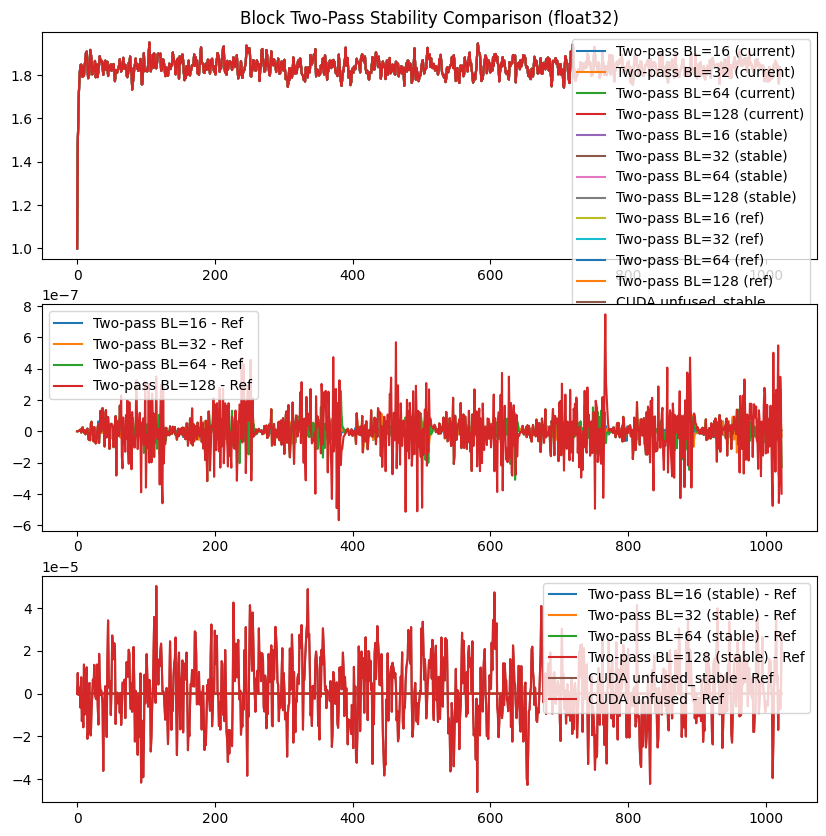

In [14]:
a = torch.rand(BS, H, N) * (a_max - a_min) + a_min
log_a = torch.log(a)
u = torch.ones(BS, H, DH, N)

with torch.no_grad():
    x_btp_bl_16 = block_two_pass(u, log_a, construct_L_logsumexp, BL=16)
    x_btp_bl_32 = block_two_pass(u, log_a, construct_L_logsumexp, BL=32)
    x_btp_bl_64 = block_two_pass(u, log_a, construct_L_logsumexp, BL=64)
    x_btp_bl_128 = block_two_pass(u, log_a, construct_L_logsumexp, BL=128)
    x_btp_bl_16_stable = block_two_pass(u, log_a, construct_L_logsumexp_stable, BL=16)
    x_btp_bl_32_stable = block_two_pass(u, log_a, construct_L_logsumexp_stable, BL=32)
    x_btp_bl_64_stable = block_two_pass(u, log_a, construct_L_logsumexp_stable, BL=64)
    x_btp_bl_128_stable = block_two_pass(u, log_a, construct_L_logsumexp_stable, BL=128)
    x_ref_bl_16 = block_two_pass(u, log_a, construct_L_ref, BL=16)
    x_ref_bl_32 = block_two_pass(u, log_a, construct_L_ref, BL=32)
    x_ref_bl_64 = block_two_pass(u, log_a, construct_L_ref, BL=64)
    x_ref_bl_128 = block_two_pass(u, log_a, construct_L_ref, BL=128)

# Compute CUDA unfused kernels (if CUDA is available and spear loaded)
y_unf_stable = None
y_unf_default_cpu = None
if torch.cuda.is_available() and HAS_SPEAR:
    device = "cuda"
    # Kernel expects DH=DH and half/bfloat16 input
    x_k = torch.ones(BS, H, DH, N, device=device, dtype=torch.float16)
    A_k = a.to(device=device, dtype=torch.float16)
    y_unf_stable = btp_ops(A_k, x_k, k=2, output_dtype=torch.float32)
    y_unf_stable_cpu = y_unf_stable.float().mean(dim=(0,1,2)).detach().cpu().numpy()
    try:
        y_unf_default = nb_unfused_forward(A_k, x_k, variant="unfused")
        y_unf_default_cpu = y_unf_default.float().mean(dim=(0,1,2)).detach().cpu().numpy()
    except Exception as e:
        print(f"[warn] CUDA unfused default failed: {e}")

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].set_title("Block Two-Pass Stability Comparison (float32)")
axs[0].plot(x_btp_bl_16.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=16 (current)")
axs[0].plot(x_btp_bl_32.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=32 (current)")
axs[0].plot(x_btp_bl_64.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=64 (current)")
axs[0].plot(x_btp_bl_128.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=128 (current)")
axs[0].plot(x_btp_bl_16_stable.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=16 (stable)")
axs[0].plot(x_btp_bl_32_stable.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=32 (stable)")
axs[0].plot(x_btp_bl_64_stable.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=64 (stable)")
axs[0].plot(x_btp_bl_128_stable.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=128 (stable)")
axs[0].plot(x_ref_bl_16.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=16 (ref)")
axs[0].plot(x_ref_bl_32.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=32 (ref)")
axs[0].plot(x_ref_bl_64.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=64 (ref)")
axs[0].plot(x_ref_bl_128.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=128 (ref)")
if y_unf_stable is not None:
    axs[0].plot(y_unf_stable_cpu, label="CUDA unfused_stable", color=PALETTE["unfused_stable"])
if y_unf_default_cpu is not None:
    axs[0].plot(y_unf_default_cpu, label="CUDA unfused", color=PALETTE["unfused"])
axs[0].legend()
axs[1].plot((x_btp_bl_16 - x_ref_bl_16).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=16 - Ref")
axs[1].plot((x_btp_bl_32 - x_ref_bl_32).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=32 - Ref")
axs[1].plot((x_btp_bl_64 - x_ref_bl_64).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=64 - Ref")
axs[1].plot((x_btp_bl_128 - x_ref_bl_128).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=128 - Ref")
axs[1].legend()
axs[2].plot((x_btp_bl_16_stable - x_ref_bl_16).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=16 (stable) - Ref")
axs[2].plot((x_btp_bl_32_stable - x_ref_bl_32).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=32 (stable) - Ref")
axs[2].plot((x_btp_bl_64_stable - x_ref_bl_64).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=64 (stable) - Ref")
axs[2].plot((x_btp_bl_128_stable - x_ref_bl_128).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=128 (stable) - Ref")
if y_unf_stable is not None:
    ref16_mean = x_ref_bl_16.float().mean(dim=(0,1,2)).cpu().numpy()
    axs[2].plot(y_unf_stable_cpu - ref16_mean, label="CUDA unfused_stable - Ref", color=PALETTE["unfused_stable"])
if y_unf_default_cpu is not None:
    ref16_mean = x_ref_bl_16.float().mean(dim=(0,1,2)).cpu().numpy()
    axs[2].plot(y_unf_default_cpu - ref16_mean, label="CUDA unfused - Ref", color=PALETTE["unfused"])
axs[2].legend()
plt.show()
fig.tight_layout()



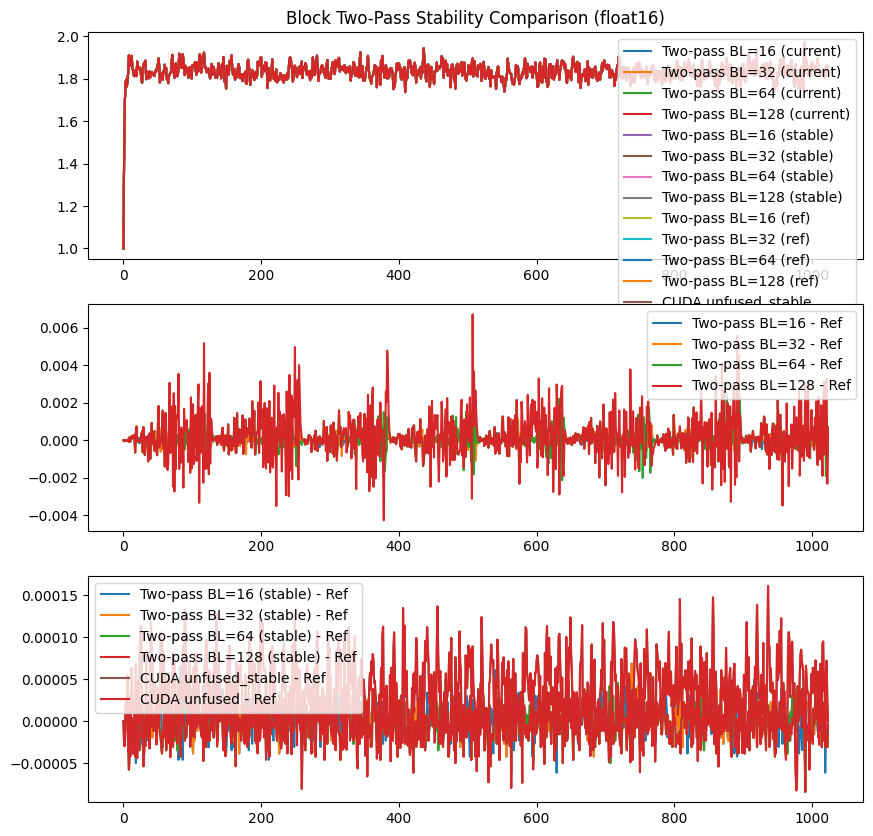

In [15]:
a = torch.rand(BS, H, N, dtype=torch.float16) * (a_max - a_min) + a_min
log_a = torch.log(a)
u = torch.ones(BS, H, DH, N, dtype=torch.float16)

with torch.no_grad():
    x_btp_bl_16 = block_two_pass(u, log_a, construct_L_logsumexp, BL=16)
    x_btp_bl_32 = block_two_pass(u, log_a, construct_L_logsumexp, BL=32)
    x_btp_bl_64 = block_two_pass(u, log_a, construct_L_logsumexp, BL=64)
    x_btp_bl_128 = block_two_pass(u, log_a, construct_L_logsumexp, BL=128)
    x_btp_bl_16_stable = block_two_pass(u, log_a, construct_L_logsumexp_stable, BL=16)
    x_btp_bl_32_stable = block_two_pass(u, log_a, construct_L_logsumexp_stable, BL=32)
    x_btp_bl_64_stable = block_two_pass(u, log_a, construct_L_logsumexp_stable, BL=64)
    x_btp_bl_128_stable = block_two_pass(u, log_a, construct_L_logsumexp_stable, BL=128)
    x_seq_bl_16 = block_two_pass(u, log_a, construct_L_ref, BL=16)
    x_seq_bl_32 = block_two_pass(u, log_a, construct_L_ref, BL=32)
    x_seq_bl_64 = block_two_pass(u, log_a, construct_L_ref, BL=64)
    x_seq_bl_128 = block_two_pass(u, log_a, construct_L_ref, BL=128)

# Compute CUDA unfused kernels (if CUDA is available and spear loaded)
y_unf_stable = None
y_unf_default_cpu = None
if torch.cuda.is_available() and HAS_SPEAR:
    device = "cuda"
    x_k = torch.ones(BS, H, DH, N, device=device, dtype=torch.float16)
    A_k = a.to(device=device, dtype=torch.float16)
    y_unf_stable = btp_ops(A_k, x_k, k=2, output_dtype=torch.float32)
    y_unf_stable_cpu = y_unf_stable.float().mean(dim=(0,1,2)).detach().cpu().numpy()
    try:
        y_unf_default = nb_unfused_forward(A_k, x_k, variant="unfused")
        y_unf_default_cpu = y_unf_default.float().mean(dim=(0,1,2)).detach().cpu().numpy()
    except Exception as e:
        print(f"[warn] CUDA unfused default failed: {e}")

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].set_title("Block Two-Pass Stability Comparison (float16)")
axs[0].plot(x_btp_bl_16.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=16 (current)")
axs[0].plot(x_btp_bl_32.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=32 (current)")
axs[0].plot(x_btp_bl_64.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=64 (current)")
axs[0].plot(x_btp_bl_128.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=128 (current)")
axs[0].plot(x_btp_bl_16_stable.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=16 (stable)")
axs[0].plot(x_btp_bl_32_stable.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=32 (stable)")
axs[0].plot(x_btp_bl_64_stable.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=64 (stable)")
axs[0].plot(x_btp_bl_128_stable.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=128 (stable)")
axs[0].plot(x_seq_bl_16.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=16 (ref)")
axs[0].plot(x_seq_bl_32.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=32 (ref)")
axs[0].plot(x_seq_bl_64.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=64 (ref)")
axs[0].plot(x_seq_bl_128.float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=128 (ref)")
if y_unf_stable is not None:
    axs[0].plot(y_unf_stable_cpu, label="CUDA unfused_stable", color=PALETTE["unfused_stable"]) 
if y_unf_default_cpu is not None:
    axs[0].plot(y_unf_default_cpu, label="CUDA unfused", color=PALETTE["unfused"])
axs[0].legend()
axs[1].plot((x_btp_bl_16 - x_seq_bl_16).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=16 - Ref")
axs[1].plot((x_btp_bl_32 - x_seq_bl_32).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=32 - Ref")
axs[1].plot((x_btp_bl_64 - x_seq_bl_64).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=64 - Ref")
axs[1].plot((x_btp_bl_128 - x_seq_bl_128).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=128 - Ref")
axs[1].legend()
axs[2].plot((x_btp_bl_16_stable - x_seq_bl_16).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=16 (stable) - Ref")
axs[2].plot((x_btp_bl_32_stable - x_seq_bl_32).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=32 (stable) - Ref")
axs[2].plot((x_btp_bl_64_stable - x_seq_bl_64).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=64 (stable) - Ref")
axs[2].plot((x_btp_bl_128_stable - x_seq_bl_128).float().mean(dim=(0,1,2)).cpu().numpy(), label="Two-pass BL=128 (stable) - Ref")
if y_unf_stable is not None:
    ref16_mean = x_seq_bl_16.float().mean(dim=(0,1,2)).cpu().numpy()
    axs[2].plot(y_unf_stable_cpu - ref16_mean, label="CUDA unfused_stable - Ref", color=PALETTE["unfused_stable"]) 
if y_unf_default_cpu is not None:
    ref16_mean = x_seq_bl_16.float().mean(dim=(0,1,2)).cpu().numpy()
    axs[2].plot(y_unf_default_cpu - ref16_mean, label="CUDA unfused - Ref", color=PALETTE["unfused"])
axs[2].legend()
plt.show()
fig.tight_layout()



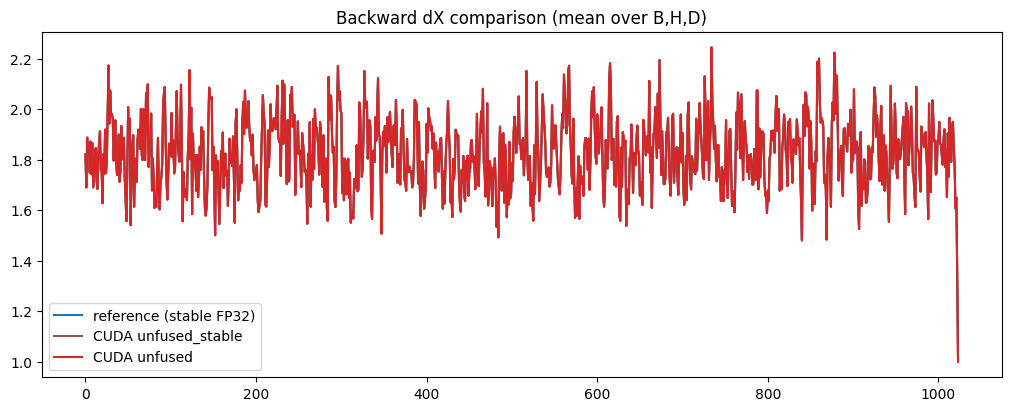

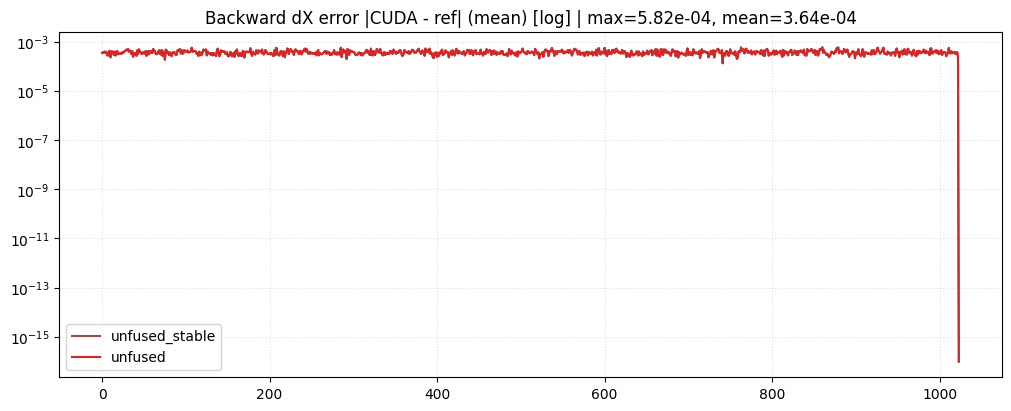

In [16]:
# Backward dX comparison (reference vs CUDA unfused_stable)
# Uses float16 inputs for the CUDA kernel; reference computed in FP32.

# Prepare inputs
use_cuda_kernel = torch.cuda.is_available() and HAS_SPEAR
device_k = "cuda" if use_cuda_kernel else "cpu"

# Random inputs (match earlier BS,H,N) and enforce DH for kernel
torch.manual_seed(0)
DH_k = DH if use_cuda_kernel else DH
A_base = torch.rand(H, N, device=device_k) * (a_max - a_min) + a_min
x_base = torch.randn(BS, H, DH_k, N, device=device_k)

# --- CUDA unfused_stable backward (if available) ---
y_unf = None
if use_cuda_kernel:
    A_k = A_base.detach().clone().to(dtype=torch.float16).requires_grad_(True)
    x_k = x_base.detach().clone().to(dtype=torch.float16).requires_grad_(True)
    y_unf = btp_ops(A_k.unsqueeze(0).expand(BS, -1, -1).contiguous(), x_k, k=2, output_dtype=torch.float32)
    upstream_unf = torch.ones_like(y_unf, dtype=torch.float32)
    y_unf.backward(upstream_unf)
    dx_unf = x_k.grad.detach().float()
    dA_unf = A_k.grad.detach().float()  # [H,L]
    # Default unfused via subprocess to avoid extension clashes
    try:
        _ydef, dx_unf_def, dA_unf_def = nb_unfused_backward(A_k.unsqueeze(0).expand(BS, -1, -1).contiguous(), x_k, variant="unfused")
    except Exception as e:
        dx_unf_def = None
        dA_unf_def = None
        print(f"[warn] CUDA unfused default backward failed: {e}")

# --- Reference backward in FP32 ---
A_r = A_base.detach().clone().to(device_k).requires_grad_(True)
x_r = x_base.detach().clone().to(device_k).requires_grad_(True)
A_r32 = A_r.float()
x_r32 = x_r.float()
A_single_r32 = A_r32.unsqueeze(0).expand(BS, -1, -1)
log_a_r32 = torch.log(A_single_r32)
y_ref = block_two_pass(x_r32, log_a_r32, construct_L_logsumexp_stable, BL=16)
upstream_ref = torch.ones_like(y_ref, dtype=torch.float32)
y_ref.backward(upstream_ref)

dx_ref = x_r.grad.detach().float()
dA_ref = A_r.grad.detach().float()  # [H,L]

# Reduce to 1D curves for visualization
ref_dx_curve = dx_ref.mean(dim=(0,1,2)).cpu().numpy()
if y_unf is not None:
    unf_dx_curve = dx_unf.mean(dim=(0,1,2)).cpu().numpy()

plt.figure(figsize=(10,4), constrained_layout=True)
plt.title("Backward dX comparison (mean over B,H,D)")
plt.plot(ref_dx_curve, label="reference (stable FP32)")
if y_unf is not None:
    plt.plot(unf_dx_curve, label="CUDA unfused_stable", color=PALETTE["unfused_stable"]) 
if use_cuda_kernel and (dx_unf_def is not None):
    plt.plot(dx_unf_def.mean(dim=(0,1,2)).cpu().numpy(), label="CUDA unfused", color=PALETTE["unfused"]) 
plt.legend()

# Error (mean abs residual) on log-scale for readability
if y_unf is not None:
    err_dx_curve = (dx_unf - dx_ref).abs().mean(dim=(0,1,2)).cpu().numpy()
    max_e = float(err_dx_curve.max())
    mean_e = float(err_dx_curve.mean())
    plt.figure(figsize=(10,4), constrained_layout=True)
    plt.title(f"Backward dX error |CUDA - ref| (mean) [log] | max={max_e:.2e}, mean={mean_e:.2e}")
    plt.semilogy(err_dx_curve + 1e-16, label="unfused_stable", color=PALETTE["unfused_stable"]) 
    if dx_unf_def is not None:
        err_dx_curve_def = (dx_unf_def - dx_ref).abs().mean(dim=(0,1,2)).cpu().numpy()
        plt.semilogy(err_dx_curve_def + 1e-16, label="unfused", color=PALETTE["unfused"]) 
    plt.grid(True, which="both", ls=":", alpha=0.4)
    plt.legend()




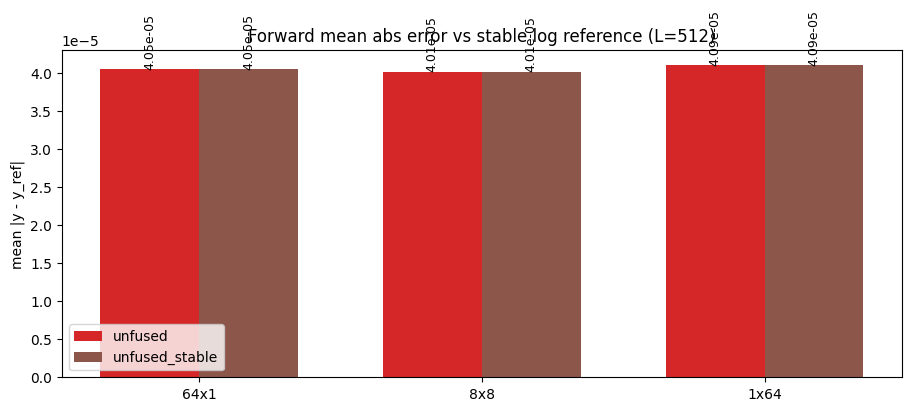

In [17]:
# Final bar graph: mean abs error vs stable log reference for unfused kernels
# Configs: (B,H) in [(64,1), (8,8), (1,64)], L=512

if not (torch.cuda.is_available() and HAS_SPEAR):
    print("[warn] CUDA or spear extension unavailable; skipping bar graph.")
else:
    from spear.ops.btp.reference import block_two_pass_log as ref_fn

    configs = [(64, 1), (8, 8), (1, 64)]
    L = 512
    DH_k = DH

    labels = [f"{B}x{H}" for (B, H) in configs]
    errs_unf = []
    errs_unf_st = []

    for (B, H) in configs:
        # Inputs: random in (0,1] for A, normal for x; half for kernels
        A = torch.sigmoid(torch.randn(B, H, L, device="cuda", dtype=torch.float16))
        x = torch.randn(B, H, DH_k, L, device="cuda", dtype=torch.float16)

        # Reference in FP32
        y_ref = ref_fn(A.float(), x.float(), BL=16).float()

        # CUDA kernels via helpers
        y_unf = nb_unfused_forward(A, x, variant="unfused").to(y_ref.dtype)
        y_unf_st = nb_unfused_forward(A, x, variant="unfused_stable").to(y_ref.dtype)

        # Mean absolute error over all dims
        errs_unf.append((y_unf - y_ref).abs().mean().item())
        errs_unf_st.append((y_unf_st - y_ref).abs().mean().item())

    import numpy as np
    x_pos = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(1, 1, figsize=(9, 4), constrained_layout=True)
    ax.bar(x_pos - width/2, errs_unf, width, label="unfused", color=PALETTE["unfused"]) 
    ax.bar(x_pos + width/2, errs_unf_st, width, label="unfused_stable", color=PALETTE["unfused_stable"]) 

    # Annotate bars with scientific notation
    for xpos, val in zip(x_pos - width/2, errs_unf):
        ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
    for xpos, val in zip(x_pos + width/2, errs_unf_st):
        ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_ylabel("mean |y - y_ref|")
    ax.set_title("Forward mean abs error vs stable log reference (L=512)")
    ax.legend()
    plt.show()


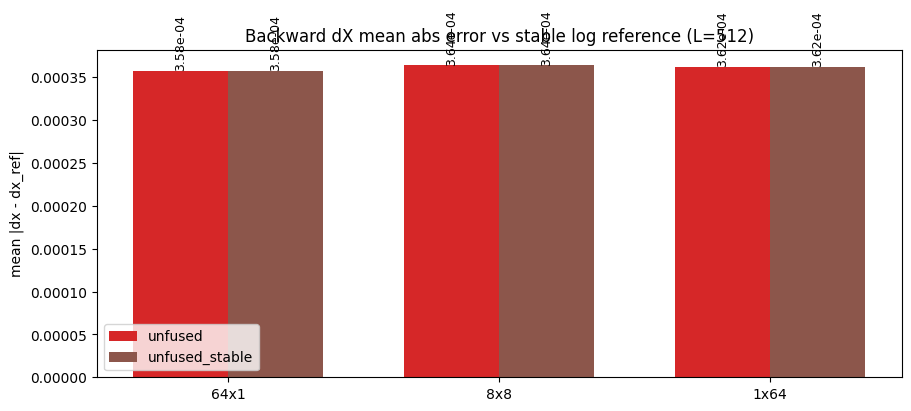

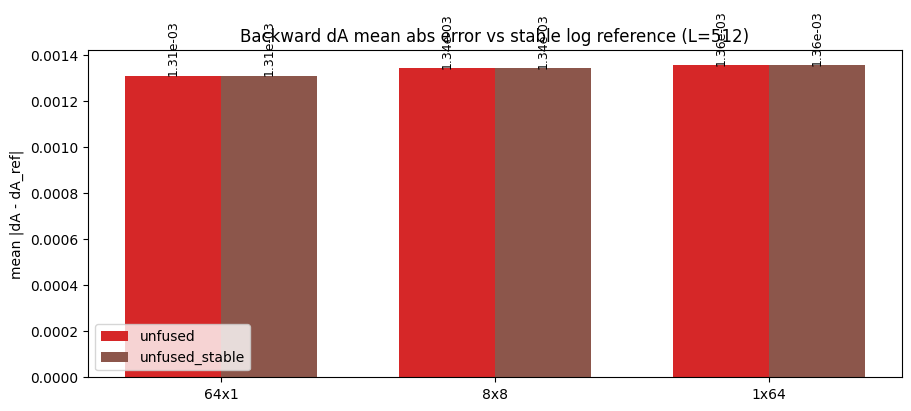

In [18]:
# Backward bar graphs: mean abs gradient error vs stable log reference
# Configs: (B,H) in [(64,1), (8,8), (1,64)], L=512

if not (torch.cuda.is_available() and HAS_SPEAR):
    print("[warn] CUDA or spear extension unavailable; skipping backward bar graphs.")
else:
    from spear.ops.btp.reference import block_two_pass_log as _stable_ref
    ref_fn = getattr(_stable_ref, "__wrapped__", _stable_ref)

    configs = [(64, 1), (8, 8), (1, 64)]
    L = 512
    DH_k = DH

    labels = [f"{B}x{H}" for (B, H) in configs]
    # dx errors (mean over B,H,D,L)
    dx_err_unf = []
    dx_err_unf_st = []
    # dA errors (mean over B,H,L)
    dA_err_unf = []
    dA_err_unf_st = []

    for (B, H) in configs:
        # Inputs on CUDA (half) for kernels
        A = torch.sigmoid(torch.randn(B, H, L, device="cuda", dtype=torch.float16))
        x = torch.randn(B, H, DH_k, L, device="cuda", dtype=torch.float16)

        # Reference grads in FP32
        A_r = A.float().detach().clone().requires_grad_(True)
        x_r = x.float().detach().clone().requires_grad_(True)
        y_ref = ref_fn(A_r, x_r, BL=16)
        upstream = torch.ones_like(y_ref, dtype=torch.float32)
        y_ref.backward(upstream)
        dx_ref = x_r.grad.detach().float()
        dA_ref = A_r.grad.detach().float()

        # CUDA kernels via helpers
        _y, dx_unf, dA_unf = nb_unfused_backward(A, x, variant="unfused")
        _y, dx_unf_st, dA_unf_st = nb_unfused_backward(A, x, variant="unfused_stable")

        # Mean absolute errors
        dx_err_unf.append((dx_unf.detach().float() - dx_ref).abs().mean().item())
        dx_err_unf_st.append((dx_unf_st.detach().float() - dx_ref).abs().mean().item())
        dA_err_unf.append((dA_unf.detach().float() - dA_ref).abs().mean().item())
        dA_err_unf_st.append((dA_unf_st.detach().float() - dA_ref).abs().mean().item())

    import numpy as np
    x_pos = np.arange(len(labels))
    width = 0.35

    # dX bar graph
    fig, ax = plt.subplots(1, 1, figsize=(9, 4), constrained_layout=True)
    ax.bar(x_pos - width/2, dx_err_unf, width, label="unfused", color=PALETTE["unfused"]) 
    ax.bar(x_pos + width/2, dx_err_unf_st, width, label="unfused_stable", color=PALETTE["unfused_stable"]) 
    for xpos, val in zip(x_pos - width/2, dx_err_unf):
        ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
    for xpos, val in zip(x_pos + width/2, dx_err_unf_st):
        ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_ylabel("mean |dx - dx_ref|")
    ax.set_title("Backward dX mean abs error vs stable log reference (L=512)")
    ax.legend()
    plt.show()

    # dA bar graph
    fig, ax = plt.subplots(1, 1, figsize=(9, 4), constrained_layout=True)
    ax.bar(x_pos - width/2, dA_err_unf, width, label="unfused", color=PALETTE["unfused"]) 
    ax.bar(x_pos + width/2, dA_err_unf_st, width, label="unfused_stable", color=PALETTE["unfused_stable"]) 
    for xpos, val in zip(x_pos - width/2, dA_err_unf):
        ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
    for xpos, val in zip(x_pos + width/2, dA_err_unf_st):
        ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_ylabel("mean |dA - dA_ref|")
    ax.set_title("Backward dA mean abs error vs stable log reference (L=512)")
    ax.legend()
    plt.show()


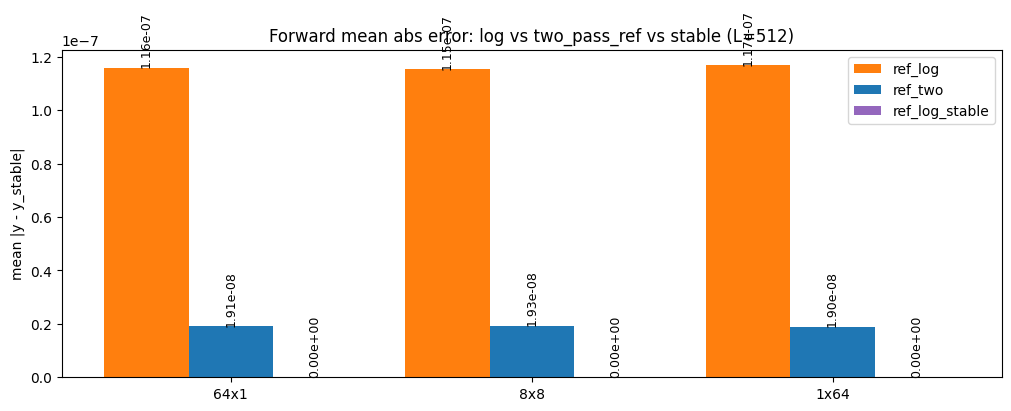

In [19]:
# Bar graph: forward mean abs error (Python ref log vs stable log vs two_pass_ref)
configs = [(64, 1), (8, 8), (1, 64)]
L = 512
DH = 16

device = "cuda" if torch.cuda.is_available() else "cpu"

labels = [f"{B}x{H}" for (B, H) in configs]
errs_ref_log = []   # |y_log - y_stable|
errs_ref_two = []   # |y_two - y_stable|
errs_ref_st = []    # zeros (baseline)

with torch.no_grad():
    for (B, H) in configs:
        a = torch.sigmoid(torch.randn(B, H, L, device=device, dtype=torch.float32))
        x = torch.randn(B, H, DH, L, device=device, dtype=torch.float32)
        loga = torch.log(a)
        y_log = block_two_pass(x, loga, construct_L_logsumexp, BL=16).float()
        y_st  = block_two_pass(x, loga, construct_L_logsumexp_stable, BL=16).float()
        y_two = block_two_pass(x, loga, construct_L_ref, BL=16).float()
        errs_ref_log.append((y_log - y_st).abs().mean().item())
        errs_ref_two.append((y_two - y_st).abs().mean().item())
        errs_ref_st.append(0.0)

import numpy as np
x_pos = np.arange(len(labels))
width = 0.28

fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)
ax.bar(x_pos - width, errs_ref_log, width, label="ref_log", color=PALETTE["ref_log"]) 
ax.bar(x_pos,         errs_ref_two, width, label="ref_two", color=PALETTE["ref_two"]) 
ax.bar(x_pos + width, errs_ref_st,  width, label="ref_log_stable", color=PALETTE["ref_log_stable"]) 

for xpos, val in zip(x_pos - width, errs_ref_log):
    ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
for xpos, val in zip(x_pos, errs_ref_two):
    ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
for xpos, val in zip(x_pos + width, errs_ref_st):
    ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylabel("mean |y - y_stable|")
ax.set_title("Forward mean abs error: log vs two_pass_ref vs stable (L=512)")
ax.legend()
plt.show()


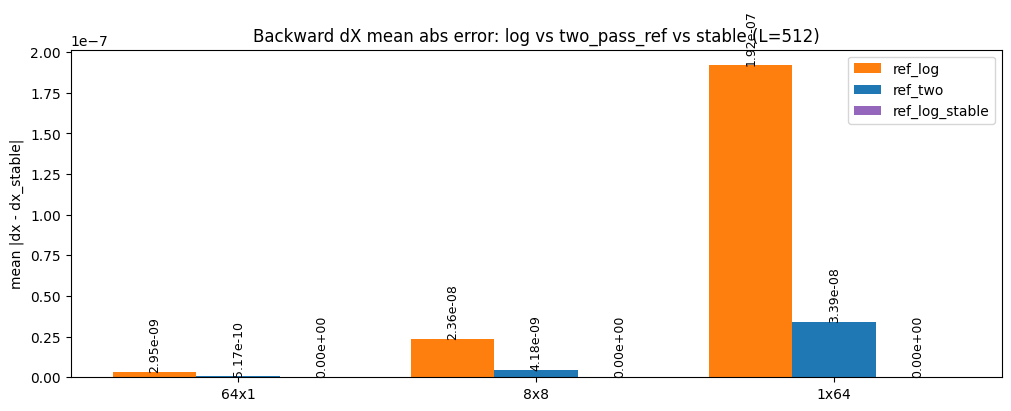

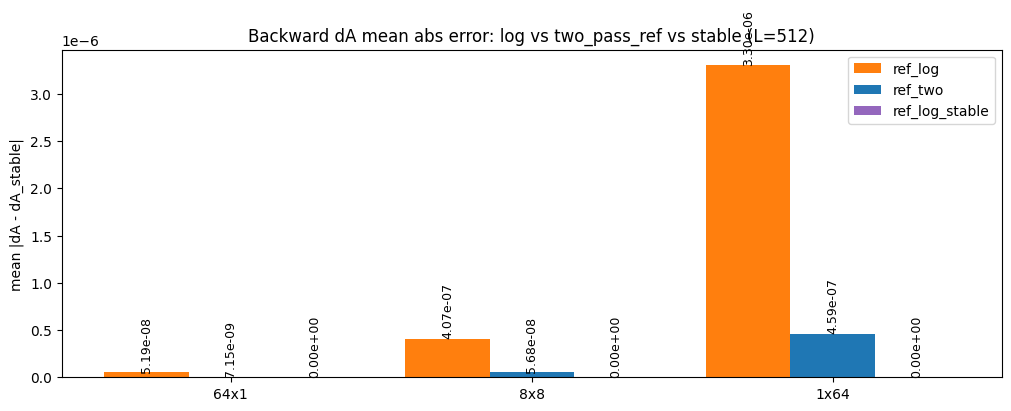

In [20]:
# Bar graphs: backward mean abs errors (Python ref log vs two_pass_ref vs stable log)
configs = [(64, 1), (8, 8), (1, 64)]
L = 512
DH = 16

device = "cuda" if torch.cuda.is_available() else "cpu"

labels = [f"{B}x{H}" for (B, H) in configs]
# dx errors (mean over B,H,D,L)
dx_err_log = []
dx_err_two = []
dx_err_st  = []  # zeros baseline
# dA errors (mean over B,H,L)
dA_err_log = []
dA_err_two = []
dA_err_st  = []  # zeros baseline

for (B, H) in configs:
    # Inputs
    a_log = torch.sigmoid(torch.randn(B, H, L, device=device, dtype=torch.float32)).detach()
    x_log = torch.randn(B, H, DH, L, device=device, dtype=torch.float32).detach()

    # Graph A: logsumexp
    a_r = a_log.clone().requires_grad_(True)
    x_r = x_log.clone().requires_grad_(True)
    y_log = block_two_pass(x_r, torch.log(a_r), construct_L_logsumexp, BL=16)
    upstream = torch.ones_like(y_log, dtype=torch.float32) * (1.0 / float(B))
    y_log.backward(upstream)
    dx_log_val = x_r.grad.detach().float(); dA_log_val = a_r.grad.detach().float()

    # Graph B: stable logsumexp
    a_s = a_log.clone().requires_grad_(True)
    x_s = x_log.clone().requires_grad_(True)
    y_st = block_two_pass(x_s, torch.log(a_s), construct_L_logsumexp_stable, BL=16)
    upstream = torch.ones_like(y_st, dtype=torch.float32) * (1.0 / float(B))
    y_st.backward(upstream)
    dx_st_val = x_s.grad.detach().float(); dA_st_val = a_s.grad.detach().float()

    # Graph C: two_pass_ref (explicit product)
    a_t = a_log.clone().requires_grad_(True)
    x_t = x_log.clone().requires_grad_(True)
    y_two = block_two_pass(x_t, torch.log(a_t), construct_L_ref, BL=16)
    upstream = torch.ones_like(y_two, dtype=torch.float32) * (1.0 / float(B))
    y_two.backward(upstream)
    dx_two_val = x_t.grad.detach().float(); dA_two_val = a_t.grad.detach().float()

    # Errors vs stable baseline
    dx_err_log.append((dx_log_val - dx_st_val).abs().mean().item())
    dx_err_two.append((dx_two_val - dx_st_val).abs().mean().item())
    dx_err_st.append(0.0)
    dA_err_log.append((dA_log_val - dA_st_val).abs().mean().item())
    dA_err_two.append((dA_two_val - dA_st_val).abs().mean().item())
    dA_err_st.append(0.0)

import numpy as np
x_pos = np.arange(len(labels))
width = 0.28

# dX bar graph
fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)
ax.bar(x_pos - width, dx_err_log, width, label="ref_log", color=PALETTE["ref_log"]) 
ax.bar(x_pos,         dx_err_two, width, label="ref_two", color=PALETTE["ref_two"]) 
ax.bar(x_pos + width, dx_err_st,  width, label="ref_log_stable", color=PALETTE["ref_log_stable"]) 
for xpos, val in zip(x_pos - width, dx_err_log):
    ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
for xpos, val in zip(x_pos, dx_err_two):
    ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
for xpos, val in zip(x_pos + width, dx_err_st):
    ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylabel("mean |dx - dx_stable|")
ax.set_title("Backward dX mean abs error: log vs two_pass_ref vs stable (L=512)")
ax.legend()
plt.show()

# dA bar graph
fig, ax = plt.subplots(1, 1, figsize=(10, 4), constrained_layout=True)
ax.bar(x_pos - width, dA_err_log, width, label="ref_log", color=PALETTE["ref_log"]) 
ax.bar(x_pos,         dA_err_two, width, label="ref_two", color=PALETTE["ref_two"]) 
ax.bar(x_pos + width, dA_err_st,  width, label="ref_log_stable", color=PALETTE["ref_log_stable"]) 
for xpos, val in zip(x_pos - width, dA_err_log):
    ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
for xpos, val in zip(x_pos, dA_err_two):
    ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
for xpos, val in zip(x_pos + width, dA_err_st):
    ax.text(xpos, val, f"{val:.2e}", ha="center", va="bottom", fontsize=9, rotation=90)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_ylabel("mean |dA - dA_stable|")
ax.set_title("Backward dA mean abs error: log vs two_pass_ref vs stable (L=512)")
ax.legend()
plt.show()
